### Ana Carolina Junger
Atividade 2 INF2137

## 1. Definição do Problema

O Dataset utilizado neste projeto é o Fake.Br Corpus, o primeiro corpus de fake news em português [Monteiro et al., 2018]. As informações foram extraídas do seu projeto no github (https://github.com/roneysco/Fake.br-Corpus). Nele, temos 3 versões do corpus: a primeira com os textos por completo + seus metadados, a segunda com os textos já pre processados pelos autores e a terceira com os pares de fake e true news truncados para terem o mesmo tamanho. Na primeira parte do projeto, iremos avaliar apenas os metadados e posteirormente os outros corpus

# 2. Iniciando o notebook + imports

In [65]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms # para tratamento de missings
from matplotlib import cm
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from loader_text_data import LoaderText
from constants import COLUNMS, STRING_COLUNMS


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 3. Carregando o Dataset

Como os dados não estavam em csv ou json, e sim em arquivos txt, foi necessário baixar os arquivos para que possamos transformar esses dados textuais em um dataframe para analise

In [61]:
class LoaderText1:
    
  def load_data(self):
    # concat index
    df_true = self.__create_dataset("true")
    df_fake = self.__create_dataset("fake")
    df_orig = pd.concat([df_true, df_fake])
    df_orig.reset_index(inplace=True) # para o index ser único
    return df_orig
  
  def __create_dataset(self, label):
    total_lines = 3602
    df = pd.DataFrame(columns=COLUNMS, data=np.empty([total_lines, len(COLUNMS)]))
    for i in range(0,total_lines):
        file_name = f"{i+1}-meta.txt"
        file_path = f"full_texts/{label}-meta-information/{file_name}"
        if (os.path.exists(file_path)):
            with open(file_path, "r", encoding="utf-8") as f:
                lines = [line.strip() for line in f.readlines()]
                df.loc[i,COLUNMS] = lines
        else:
            df.drop(index=i, inplace=True)
    df["label"] = df["link"].apply(lambda x: 1 if label == "true" else 0)
    return df
  
  def get_number_coluns(self, df):
    return list(set(df.columns) - set(STRING_COLUNMS))
  
  def get_df_with_transform_types(self, df):
      number_coluns = self.get_number_coluns(df)
      df.replace("None", np.nan, inplace=True)
      df[number_coluns] = df[number_coluns].astype(float)
      return df

In [67]:
loader = LoaderText()
df_orig = loader.load_data()
df = loader.get_df_with_transform_types(df_orig)
number_coluns = loader.get_number_coluns(df)

In [2]:
colunms = [
  "author",
  "link",
  "category",
  "date of publication",
  "number of tokens",
  "number of words without punctuation",
  "number of types",
  "number of links inside the news",
  "number of words in upper case",
  "number of verbs",
  "number of subjuntive and imperative verbs",
  "number of nouns",
  "number of adjectives",
  "number of adverbs",
  "number of modal verbs (mainly auxiliary verbs)",
  "number of singular first and second personal pronouns",
  "number of plural first personal pronouns",
  "number of pronouns",
  "pausality",
  "number of characters",
  "average sentence length",
  "average word length",
  "percentage of news with speeling errors",
  "emotiveness",
  "diversity",
]

In [ ]:
colunms = [
  "author",
  "link",
  "category",
  "date of publication",
  "number of tokens",
  "number of words without punctuation",
  "number of types",
  "number of links inside the news",
  "number of words in upper case",
  "number of verbs",
  "number of subjuntive and imperative verbs",
  "number of nouns",
  "number of adjectives",
  "number of adverbs",
  "number of modal verbs (mainly auxiliary verbs)",
  "number of singular first and second personal pronouns",
  "number of plural first personal pronouns",
  "number of pronouns",
  "pausality",
  "number of characters",
  "average sentence length",
  "average word length",
  "percentage of news with speeling errors",
  "emotiveness",
  "diversity",
]

In [3]:
# positive dataset
def create_dataset(label):
    total_lines = 3602
    df = pd.DataFrame(columns=colunms, data=np.empty([total_lines, len(colunms)]))
    for i in range(0,total_lines):
        file_name = f"{i+1}-meta.txt"
        file_path = f"full_texts/{label}-meta-information/{file_name}"
        if (os.path.exists(file_path)):
            with open(file_path, "r", encoding="utf-8") as f:
                lines = [line.strip() for line in f.readlines()]
                df.loc[i,colunms] = lines
        else:
            df.drop(index=i, inplace=True)
    df["label"] = df["link"].apply(lambda x: 1 if label == "true" else 0)
    return df

In [4]:
# concat index
df_true = create_dataset("true")
df_fake = create_dataset("fake")
df_orig = pd.concat([df_true, df_fake])
df_orig.reset_index(inplace=True) # para o index ser único

In [5]:
df = df_orig.copy()

Como o arquivo era em formato de texto, é necessário transformar as colunas com atributos numérios no tipo float.

Utilizei float para normalizar as numéricas, visto que alguns números eram decimais.

In [6]:
# transformando colunas numericas em float

string_coluns = ['index', 'author', 'link', 'category', 'date of publication', "label"]
number_coluns = list(set(df.columns) - set(string_coluns))
df.replace("None", np.nan, inplace=True)
df[number_coluns] = df[number_coluns].astype(float)
number_coluns

['emotiveness',
 'number of links inside the news',
 'average sentence length',
 'number of singular first and second personal pronouns',
 'average word length',
 'number of subjuntive and imperative verbs',
 'number of types',
 'number of verbs',
 'diversity',
 'number of adjectives',
 'number of pronouns',
 'number of characters',
 'number of plural first personal pronouns',
 'number of modal verbs (mainly auxiliary verbs)',
 'number of adverbs',
 'pausality',
 'percentage of news with speeling errors',
 'number of words in upper case',
 'number of nouns',
 'number of tokens',
 'number of words without punctuation']

## 4. Análise exploratória dos dados

### 4.1. Estatísticas Descritivas

Vamos iniciar examinando as dimensões do dataset, suas informações e alguns exemplos de linhas.

In [7]:
print("Dataset shape", df.shape)
df.info()

Dataset shape (7200, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 27 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   index                                                  7200 non-null   int64  
 1   author                                                 3625 non-null   object 
 2   link                                                   7200 non-null   object 
 3   category                                               7200 non-null   object 
 4   date of publication                                    7200 non-null   object 
 5   number of tokens                                       7200 non-null   float64
 6   number of words without punctuation                    7200 non-null   float64
 7   number of types                                        7200 non-null   float64
 8   number of links inside 

In [8]:
df.describe()

,index,number of tokens,number of words without punctuation,number of types,number of links inside the news,number of words in upper case,number of verbs,number of subjuntive and imperative verbs,number of nouns,number of adjectives,...,number of plural first personal pronouns,number of pronouns,pausality,number of characters,average sentence length,average word length,percentage of news with speeling errors,emotiveness,diversity,label
count,7200.000000,7200.000000,7200.000000,7200.000000,5807.000000,7200.000000,7200.00000,7200.000000,7200.000000,7200.000000,...,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000
mean,1800.899444,742.763333,646.172222,306.896250,0.215085,7.680694,100.76750,4.063194,182.920278,33.154444,...,0.502639,38.758056,2.755722,3138.628333,18.229019,4.845171,0.003065,0.209758,0.577903,0.500000
std,1039.990969,774.155454,674.901525,260.201075,0.604319,9.860613,108.03151,5.492677,186.507322,39.702327,...,1.697008,51.759915,1.154137,3283.090323,6.090270,0.246260,0.007780,0.070239,0.126475,0.500035
min,0.000000,11.000000,9.000000,9.000000,0.000000,0.000000,1.00000,0.000000,3.000000,0.000000,...,0.000000,0.000000,0.250000,34.000000,2.666670,3.615940,0.000000,0.000000,0.232210,0.000000
25%,900.750000,183.000000,157.000000,106.000000,0.000000,2.000000,26.00000,1.000000,46.000000,7.000000,...,0.000000,8.000000,2.166670,755.000000,14.372850,4.696408,0.000000,0.162500,0.471089,0.000000
50%,1801.500000,416.000000,362.000000,208.000000,0.000000,5.000000,57.00000,2.000000,106.000000,18.000000,...,0.000000,19.000000,2.684015,1756.500000,18.115250,4.846540,0.000579,0.204082,0.577402,0.500000
75%,2701.250000,1064.250000,928.250000,440.000000,0.000000,10.000000,141.00000,5.000000,265.000000,45.000000,...,0.000000,49.000000,3.224992,4523.000000,21.823775,4.994038,0.003799,0.251055,0.676276,1.000000
max,3601.000000,8634.000000,7588.000000,2805.000000,11.000000,233.000000,1148.00000,65.000000,2170.000000,532.000000,...,54.000000,720.000000,51.238100,37381.000000,110.250000,5.935780,0.382353,0.750000,1.000000,1.000000


Dos atributos tipo string o que se faz necessário é apenas a categoria, visto que as outras colunas são apenas referências as notícias como link, autor e data 

In [9]:
# Transformando Variáveis Categoricas 

encoder = OrdinalEncoder()
df_include_category = df.copy()
df_include_category[["category"]] = encoder.fit_transform(df[["category"]])

In [10]:
df.groupby('label').mean()

C:\Users\55219\AppData\Local\Temp\ipykernel_107016\2301036914.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('label').mean()


,index,number of tokens,number of words without punctuation,number of types,number of links inside the news,number of words in upper case,number of verbs,number of subjuntive and imperative verbs,number of nouns,number of adjectives,...,number of singular first and second personal pronouns,number of plural first personal pronouns,number of pronouns,pausality,number of characters,average sentence length,average word length,percentage of news with speeling errors,emotiveness,diversity
label,,,,,,,,,,,,,,,,,,,,,
0,1800.899444,216.236667,185.785833,119.357778,0.346944,3.708333,31.210556,1.352500,53.470833,9.254444,...,0.494167,0.127778,11.021667,2.468517,896.441944,15.307048,4.824780,0.003859,0.205708,0.680282
1,1800.899444,1269.290000,1106.558611,494.434722,0.000000,11.653056,170.324444,6.773889,312.369722,57.054444,...,3.176944,0.877500,66.494444,3.042928,5380.814722,21.150989,4.865561,0.002270,0.213808,0.475524


Analisando a média dos atributos agrupados por categorias, já percebemos que há uma diferença entre as linguagens de uma notícia falsa e uma notícia verdadeira. Isso pode explicar os bons resultados que serão apresentados mais a frente. 

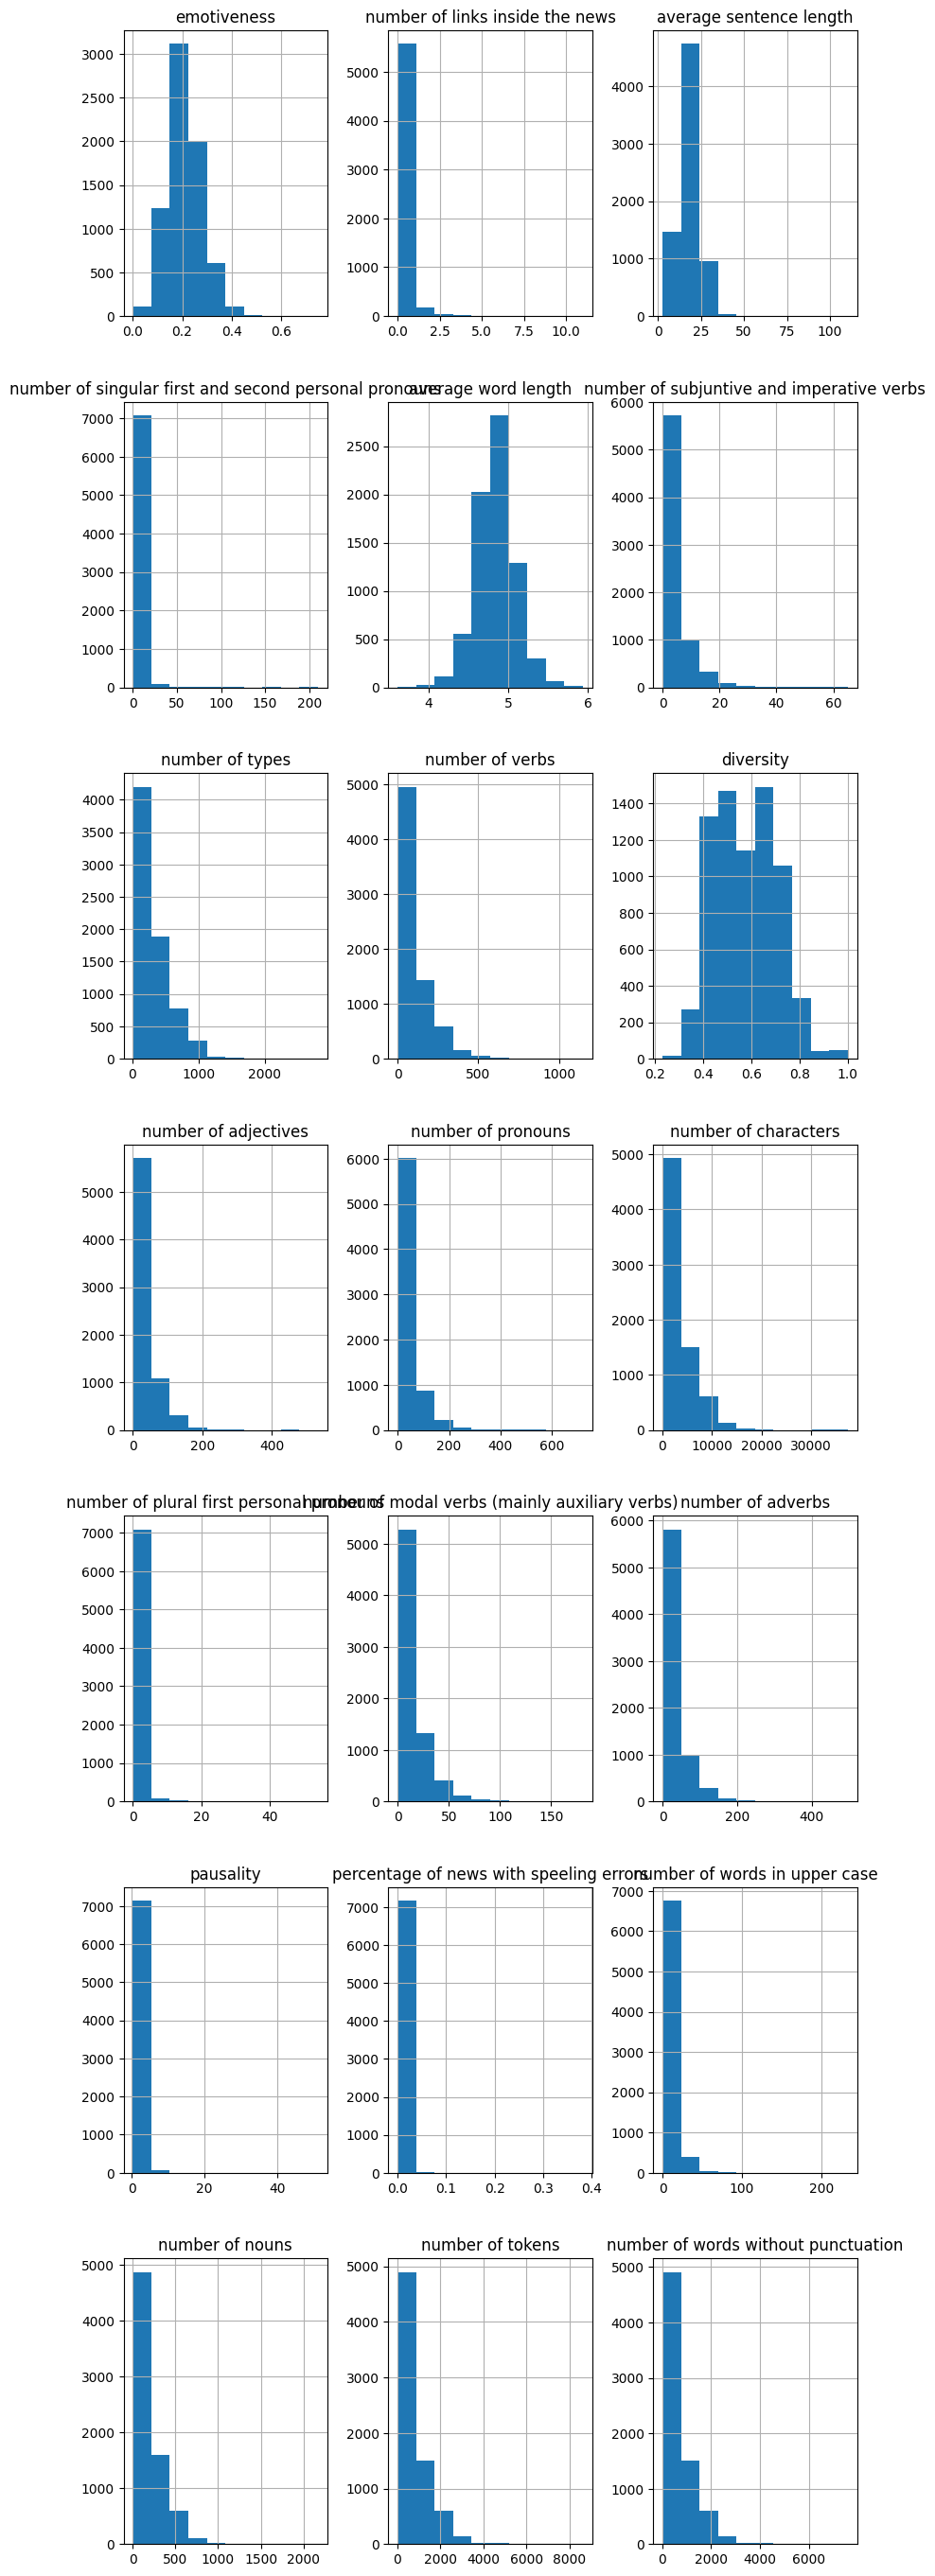

In [11]:
df[number_coluns].hist(figsize = (10,60), layout=(12,3) )
plt.show()

number of promnouns = A maioria dos dados tem menos que 200, pode ser um atributo descartado, mas tem que ser avaliado para que não desbalanceie o dataset

diversity = Tem uma distribuição basicamente normal

number of adjectives =  A maioria dos dados tem menos que 200, pode ser um atributo descartado, mas tem que ser avaliado para que não desbalanceie o dataset

emotiveness = Tem uma distribuição basicamente normal, mas mais deslocada para esquerda, com alguns outliers maiores que 0.4

average word lenght = Tem uma distribuição basicamente normal

number of verbs =  A maioria dos dados tem menos que 500, pode ser um atributo descartado ou descartar as linhas fora deste intervalo, mas tem que ser avaliado para que não desbalanceie o dataset

number of singular first and seconde personal pronous = A maioria dos dados tem menos que 50, pode ser um atributo descartado ou descartar as linhas fora deste intervalo, mas tem que ser avaliado para que não desbalanceie o dataset.

number of characters = A maioria dos dados tem menos que 1000, pode ser um atributo descartado ou descartar as linhas fora deste intervalo, mas tem que ser avaliado para que não desbalanceie o dataset

number of nouns = A maioria dos dados tem menos que 500, pode ser um atributo descartado ou descartar as linhas fora deste intervalo, mas tem que ser avaliado para que não desbalanceie o dataset

pausality = A maioria dos dados tem menos que 10, pode ser um atributo descartado ou descartar as linhas fora deste intervalo, mas tem que ser avaliado para que não desbalanceie o dataset

average sentence lenght = Tem uma maior consentração por volta dos 20-25, mas também tem um pouco ao redor 

number of subjuntive and imperative verbs = A maioria dos dados tem menos que 20, pode ser um atributo descartado ou descartar as linhas fora deste intervalo, mas tem que ser avaliado para que não desbalanceie o dataset

number of adverbs = A maioria dos dados tem menos que 100, pode ser um atributo descartado ou descartar as linhas fora deste intervalo, mas tem que ser avaliado para que não desbalanceie o dataset

number of types = A maioria dos dados tem menos que 1000, pode ser um atributo descartado ou descartar as linhas fora deste intervalo, mas tem que ser avaliado para que não desbalanceie o dataset

number of modal verbs = A maioria dos dados tem menos que 50, pode ser um atributo descartado ou descartar as linhas fora deste intervalo, mas tem que ser avaliado para que não desbalanceie o dataset

number of plural first personal pronous = A maioria dos dados tem menos que 10, pode ser um atributo descartado ou descartar as linhas fora deste intervalo, mas tem que ser avaliado para que não desbalanceie o dataset

number of links inside the news = A maioria dos dados tem menos que 2, pode ser um atributo descartado ou descartar as linhas fora deste intervalo, mas tem que ser avaliado para que não desbalanceie o dataset

number of words in upper case = A maioria dos dados tem menos que 50, pode ser um atributo descartado ou descartar as linhas fora deste intervalo, mas tem que ser avaliado para que não desbalanceie o dataset. Este atributo é bem interessante por é muito frequente o uso de palavras com letra maiuscula em noticias falsas, ele pode ser um viés para indicar uma fake news.

number of words without punctuacion = A maioria dos dados tem menos que 2000, pode ser um atributo descartado ou descartar as linhas fora deste intervalo, mas tem que ser avaliado para que não desbalanceie o dataset

percentage of news with spelling error = A maioria dos dados tem menos que 0.05, pode ser um atributo descartado ou descartar as linhas fora deste intervalo, mas tem que ser avaliado para que não desbalanceie o dataset

number of tokens = A maioria dos dados tem menos que 2000, pode ser um atributo descartado ou descartar as linhas fora deste intervalo, mas tem que ser avaliado para que não desbalanceie o dataset

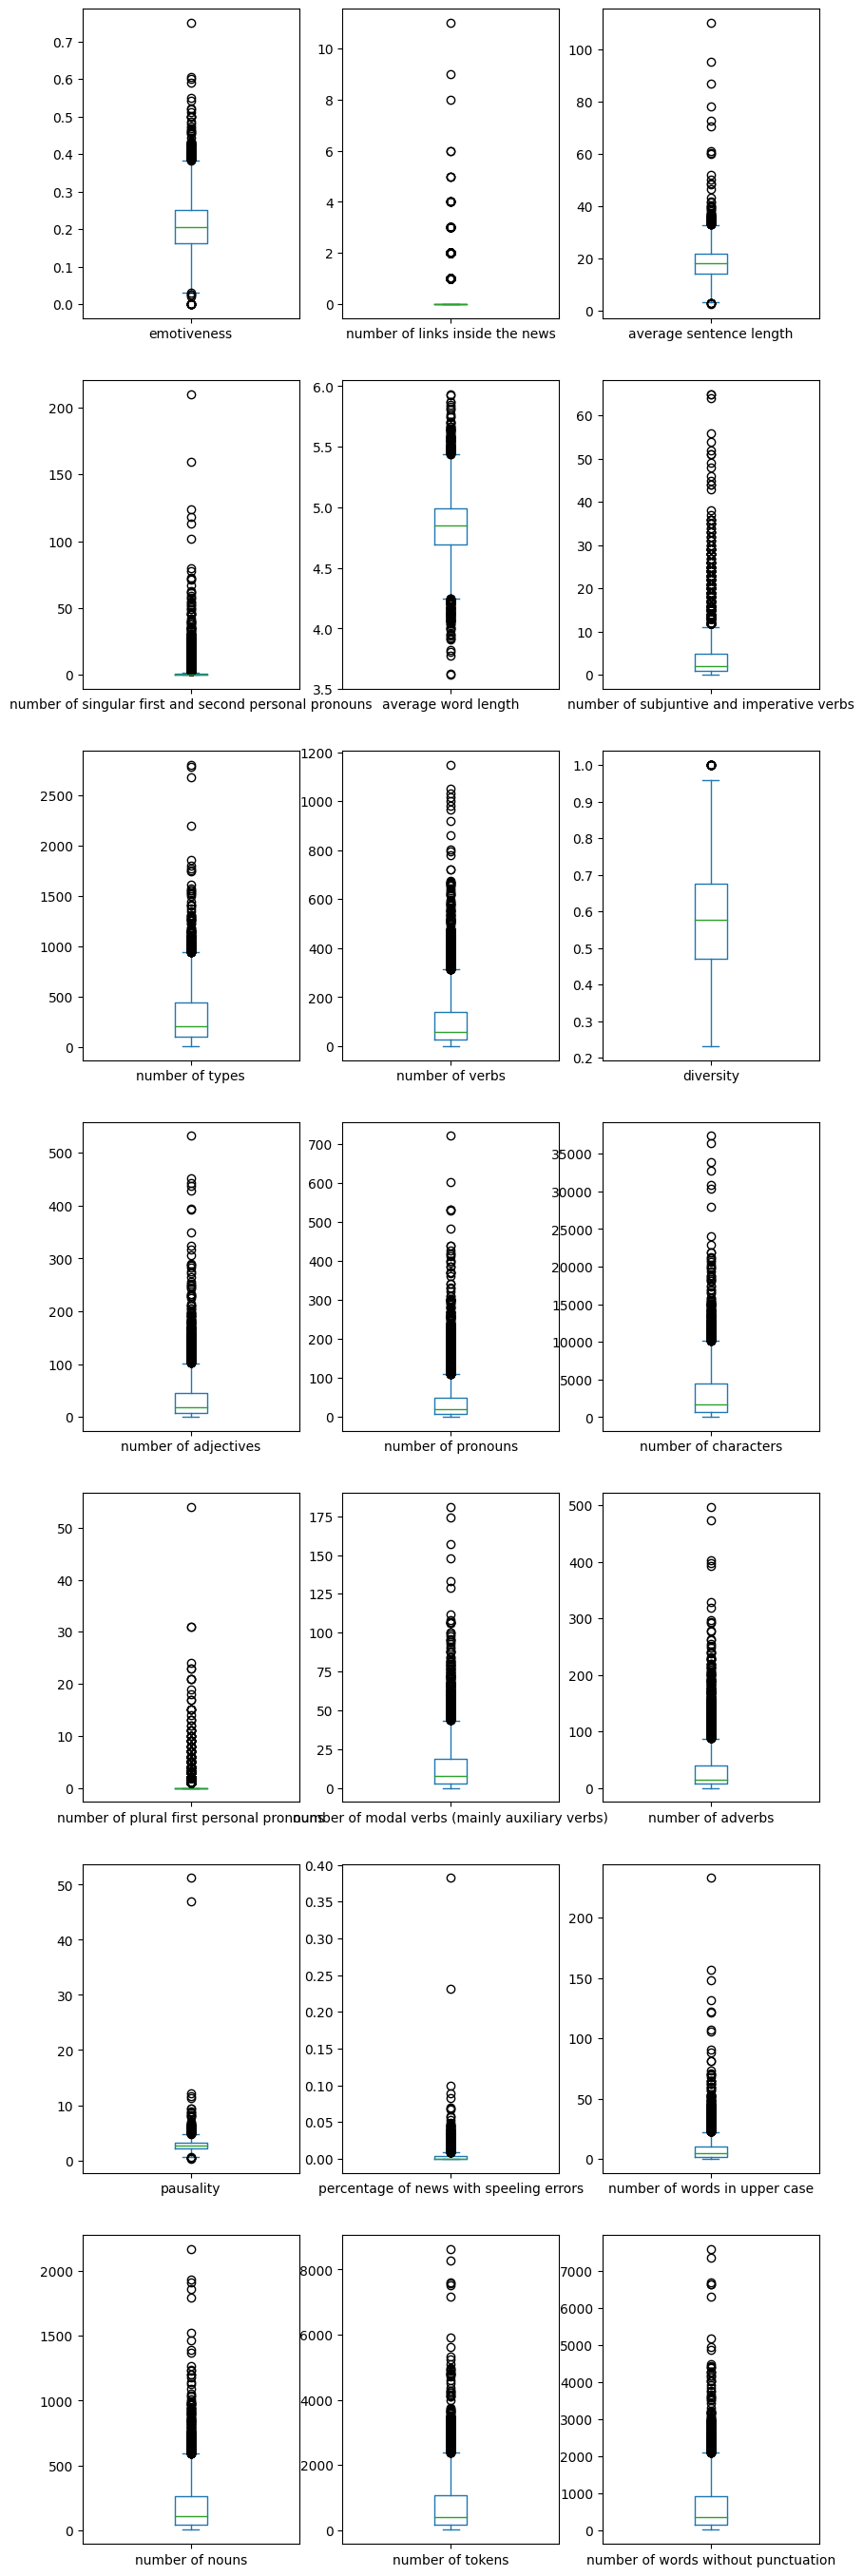

In [12]:
df[number_coluns].plot(kind = 'box', subplots = True, layout = (12,3), sharex = False, sharey = False, figsize = (10,60))
plt.show()

<Axes: >

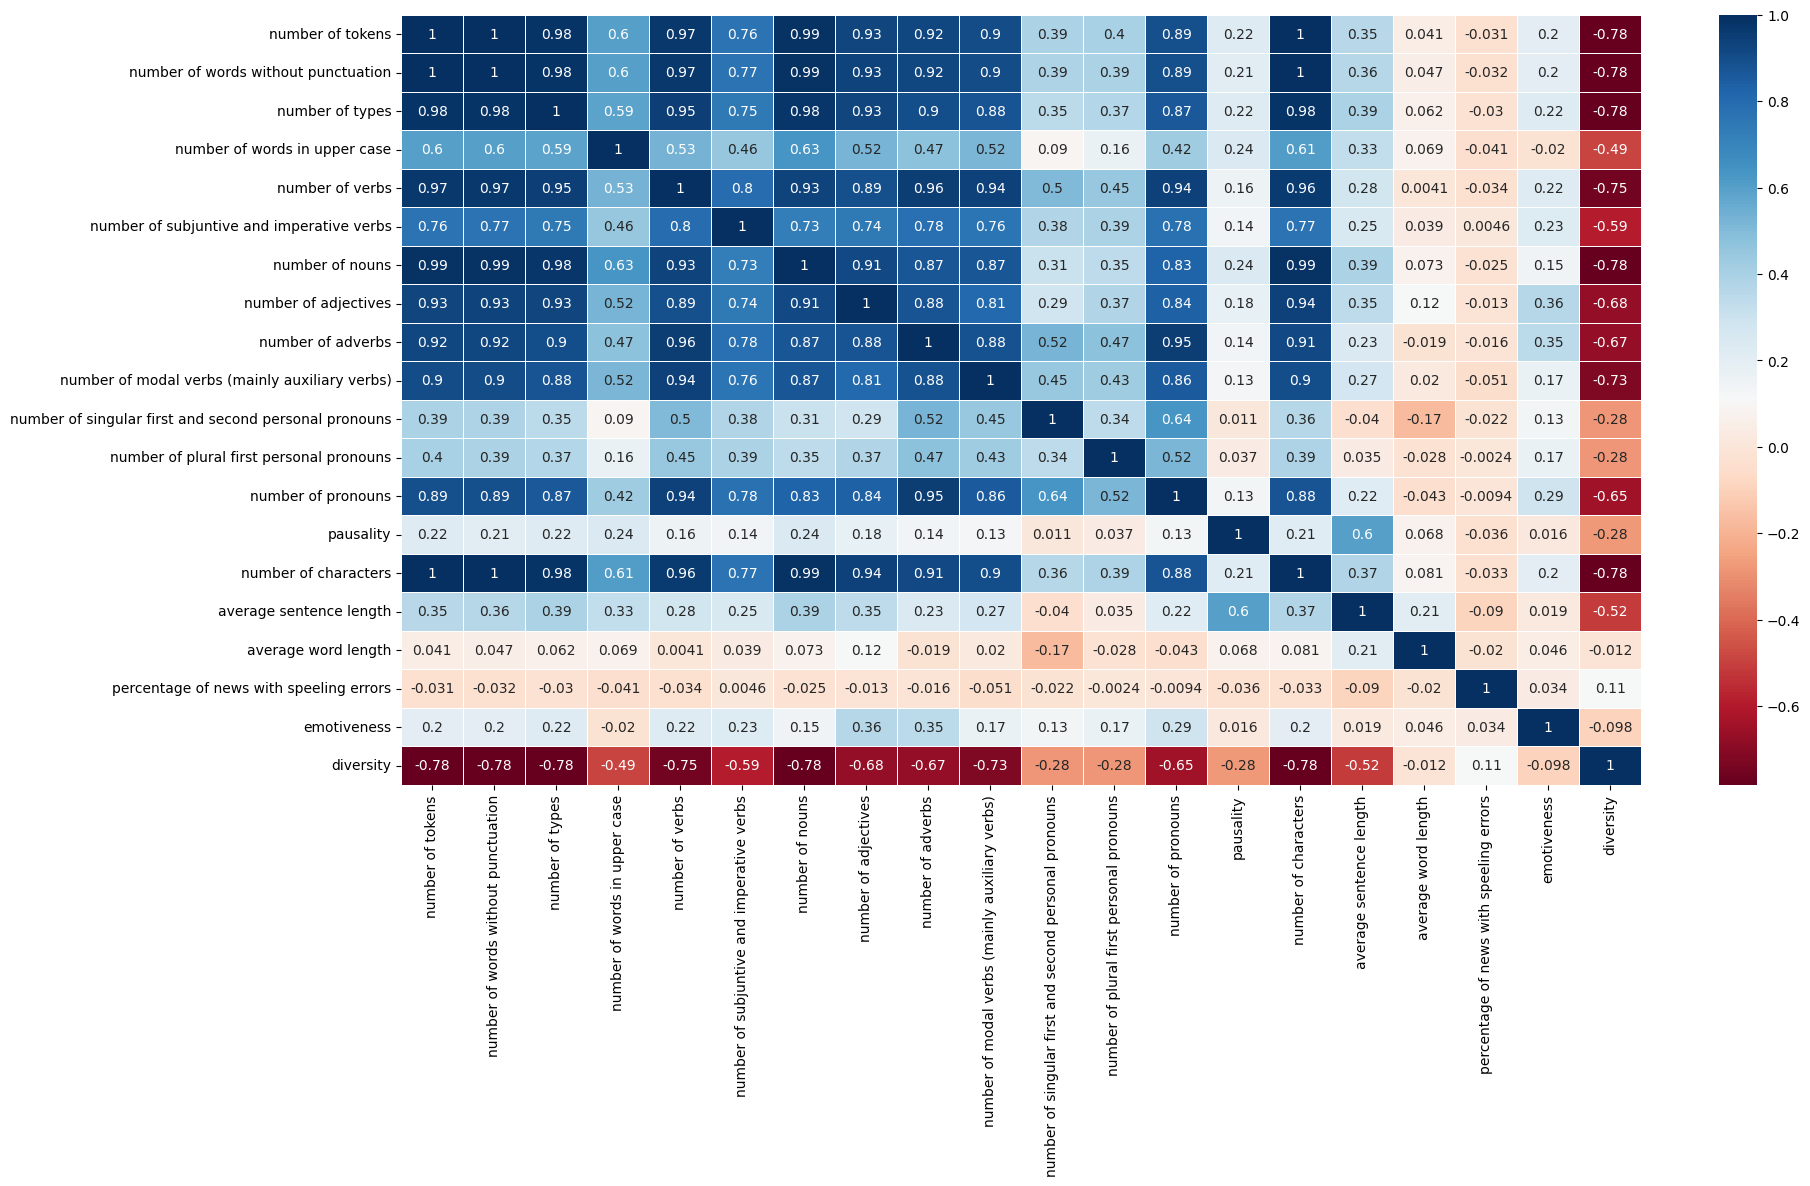

In [32]:
# Matriz de Correlação com Matplotlib Seaborn
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
sns.heatmap(df.loc[:, (df.columns != 'label') & (df.columns != 'index')].corr(), annot=True, linewidths=.5, ax=ax,  cmap='RdBu')
# sns.heatmap(df.corr(), annot=True, cmap='RdBu');

Como podemos observar a correlação da maioria dos atributos é muito forte. Já que estamos tratando de features linguisticas, já era esperado que principalmente atributos relativos a alguma contagem (palavras, verbos, substantivos) tivessem uma correlação forte, visto que se complementam na estrutura da frase. 

1. number of tokens, number of words without punctuation, number of types e number of characteres estão altamente correlacionados positivamente. Iremos selecionar apenas number of tokens. 

2. number of verbs está fortemente correlacionado (~> 0.9) com todas as contagems dos aspectos linguisticos. Vamos retira-lo da analise.

3. number of tokens esta fortemente correlacionado com as contagems dos aspectos linguisticos (a maioria ~> 0.9), mas os atributos de contagem também estão relacionados entre si. Nesse sentido avaliaremos dois cenários: removendo o "number of tokens" e removendo os atributos de contagem

<Axes: >

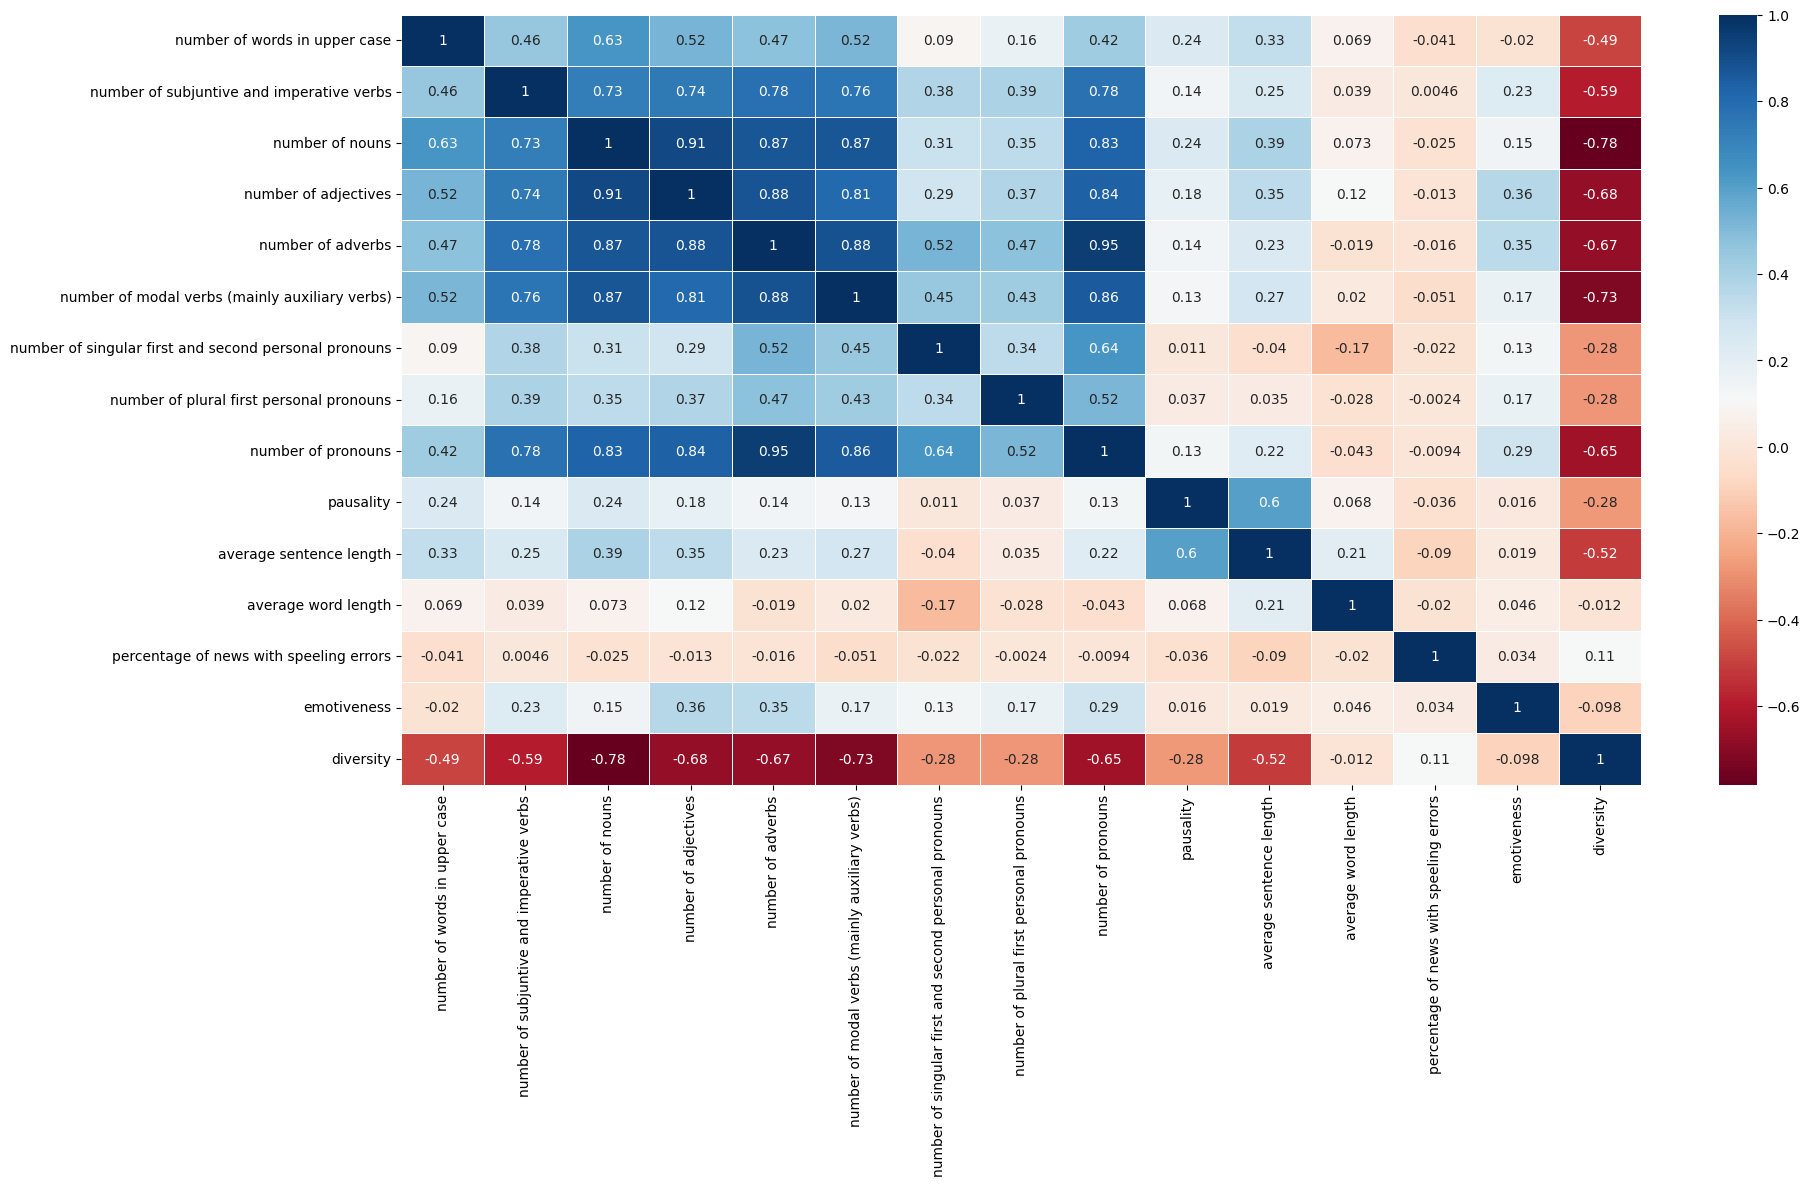

In [40]:
df_filtered_1 = df.drop(["number of words without punctuation", 
                       "number of types", 
                       "number of characters",
                       "number of verbs",
                       "number of tokens"], axis=1)
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
sns.heatmap(df_filtered.loc[:, 
            (df_filtered_1.columns != 'label') & (df_filtered_1.columns != 'index')].corr(), 
            annot=True, linewidths=.5, ax=ax,  cmap='RdBu')

<Axes: >

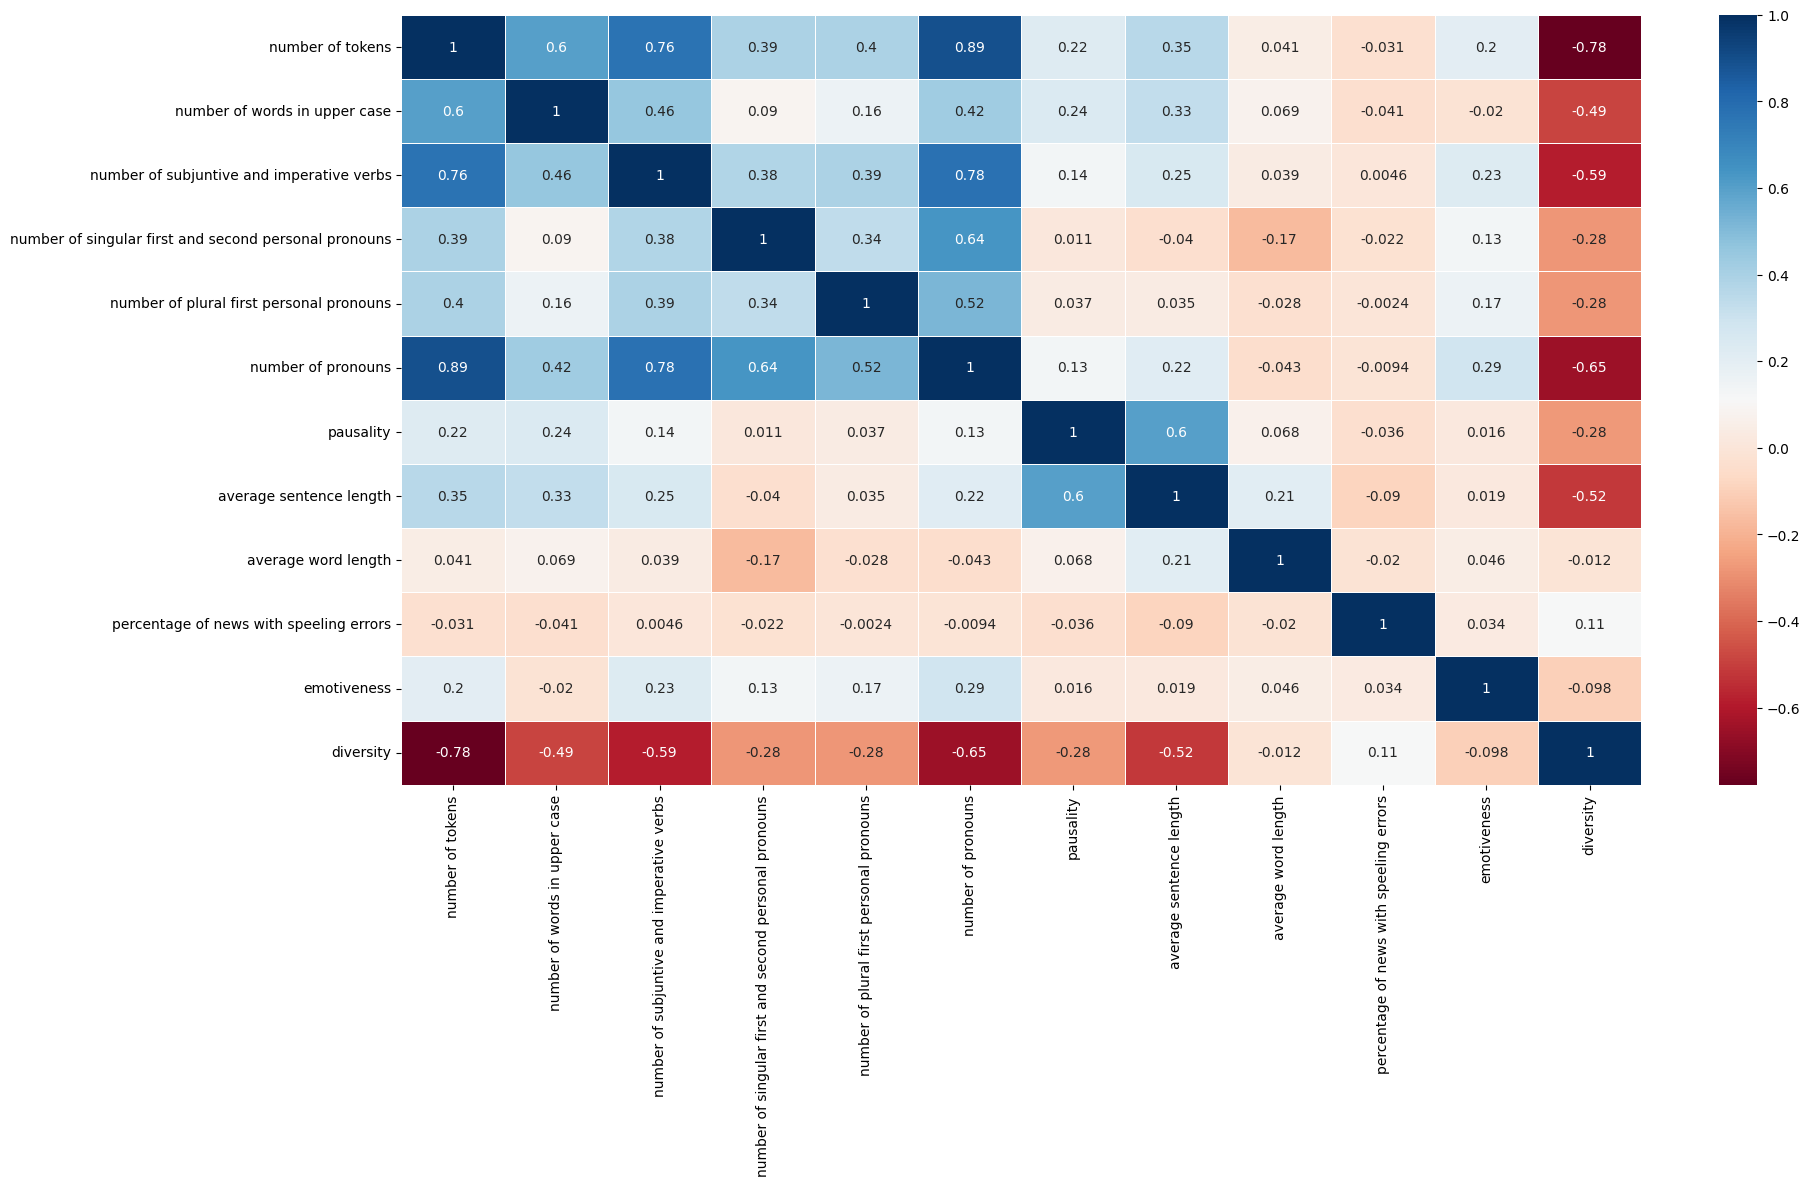

In [44]:
df_filtered_2 = df.drop(["number of words without punctuation", 
                       "number of types", 
                       "number of characters",
                       "number of verbs",
                       "number of nouns",
                       "number of adjectives",
                       "number of adverbs",
                       "number of modal verbs (mainly auxiliary verbs)",], axis=1)
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
sns.heatmap(df_filtered_2.loc[:, (df_filtered_2.columns != 'label') & (df_filtered_2.columns != 'index')].corr(), annot=True, linewidths=.5, ax=ax,  cmap='RdBu')

Podemos perceber que no segundo cenário temos menos correlação entre os dados

# 5. Pre-Processamento dos Dados

In [13]:
# verificando quantitade de nulls no dataframe
df.isnull().sum()

index                                                       0
author                                                   3575
link                                                        0
category                                                    0
date of publication                                         0
number of tokens                                            0
number of words without punctuation                         0
number of types                                             0
number of links inside the news                          1393
number of words in upper case                               0
number of verbs                                             0
number of subjuntive and imperative verbs                   0
number of nouns                                             0
number of adjectives                                        0
number of adverbs                                           0
number of modal verbs (mainly auxiliary verbs)              0
number o

<Axes: >

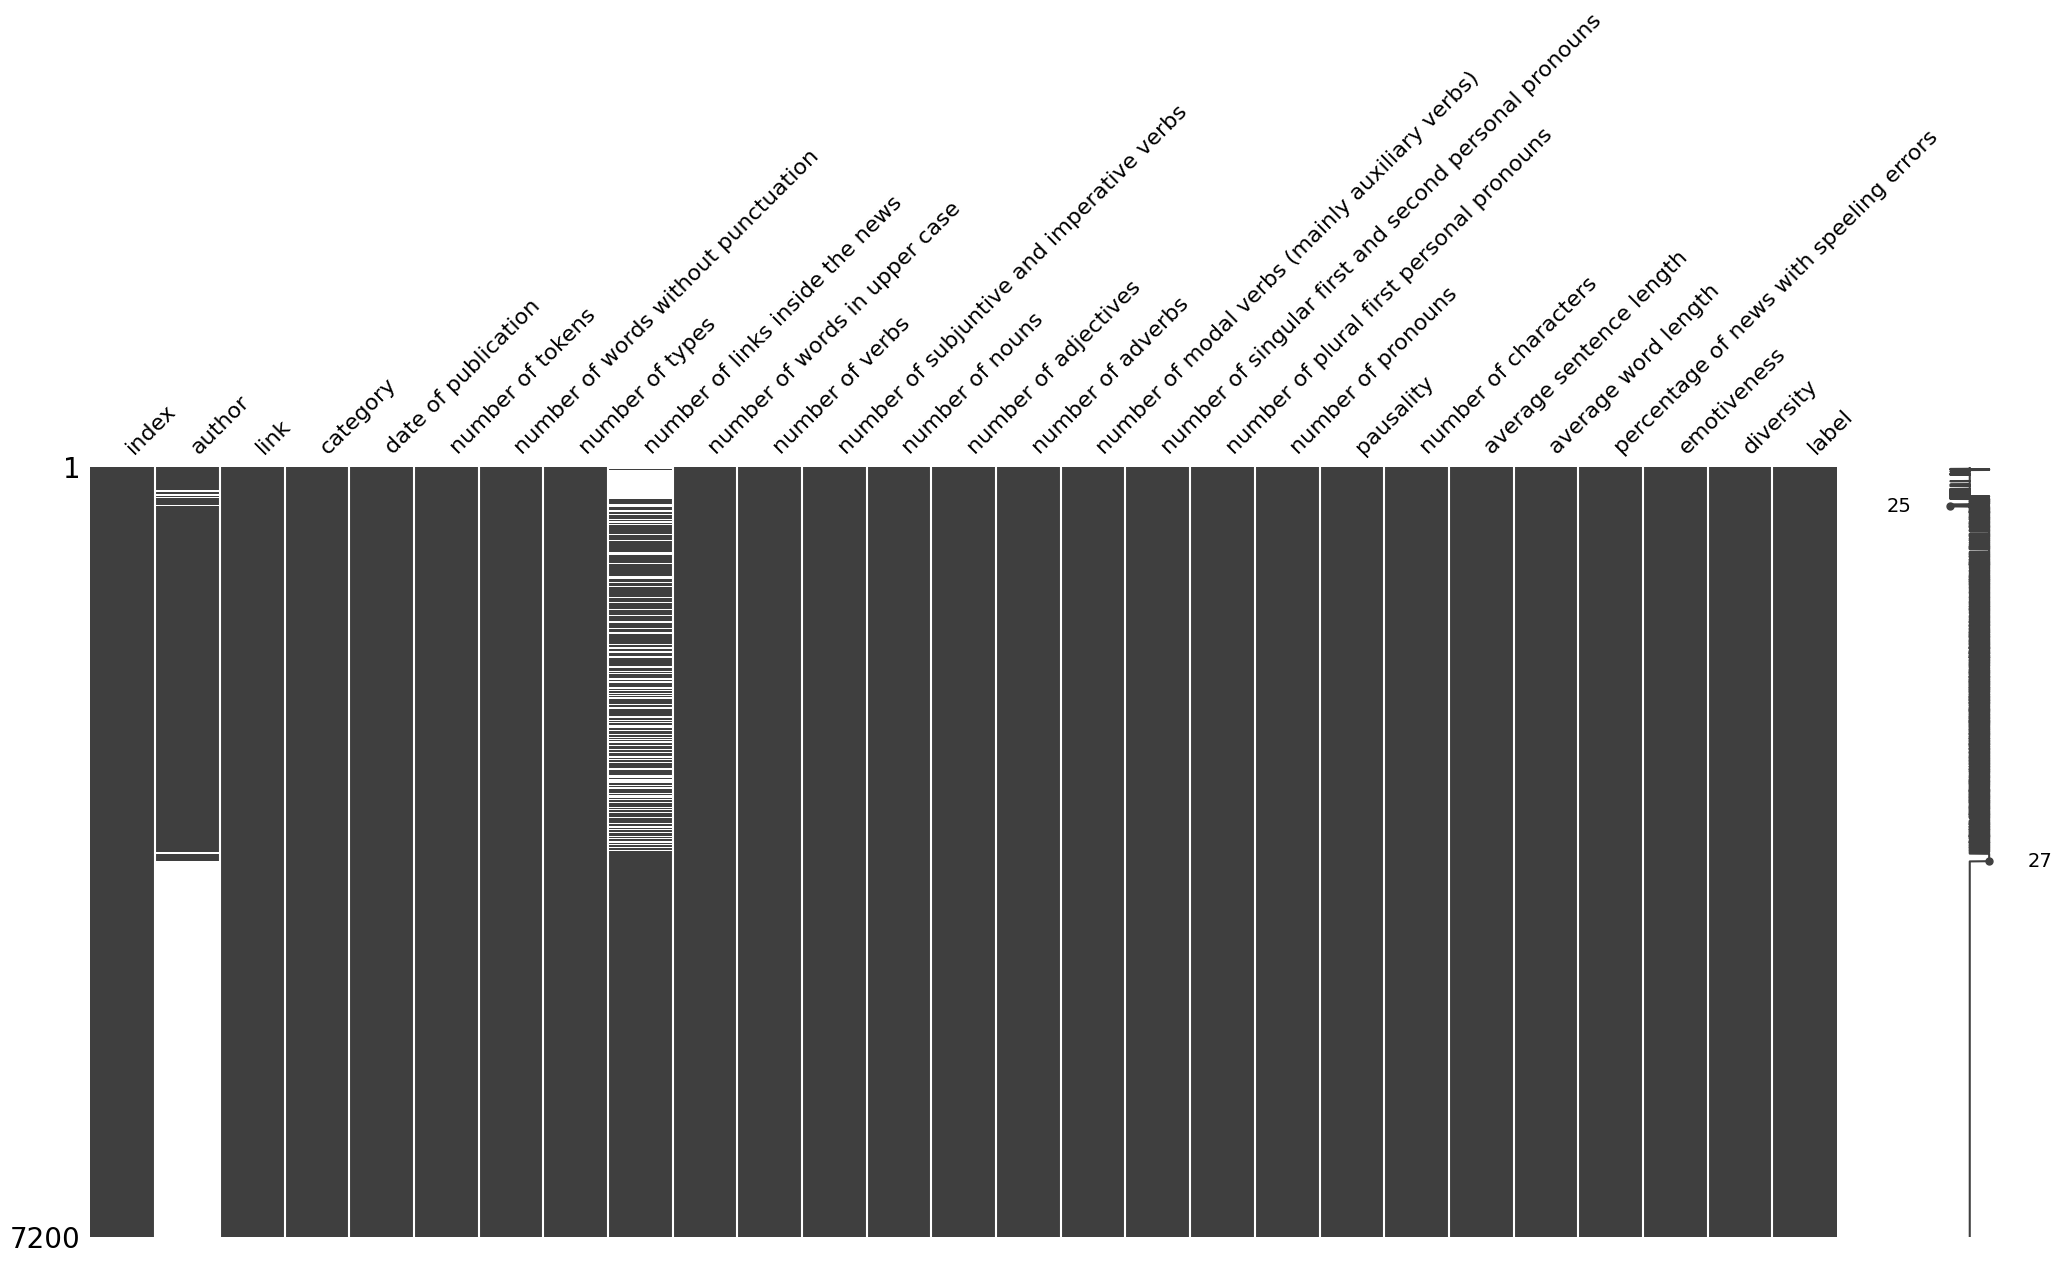

In [14]:
# exibindo visualização matricial da nulidade do dataset
ms.matrix(df)

<Axes: >

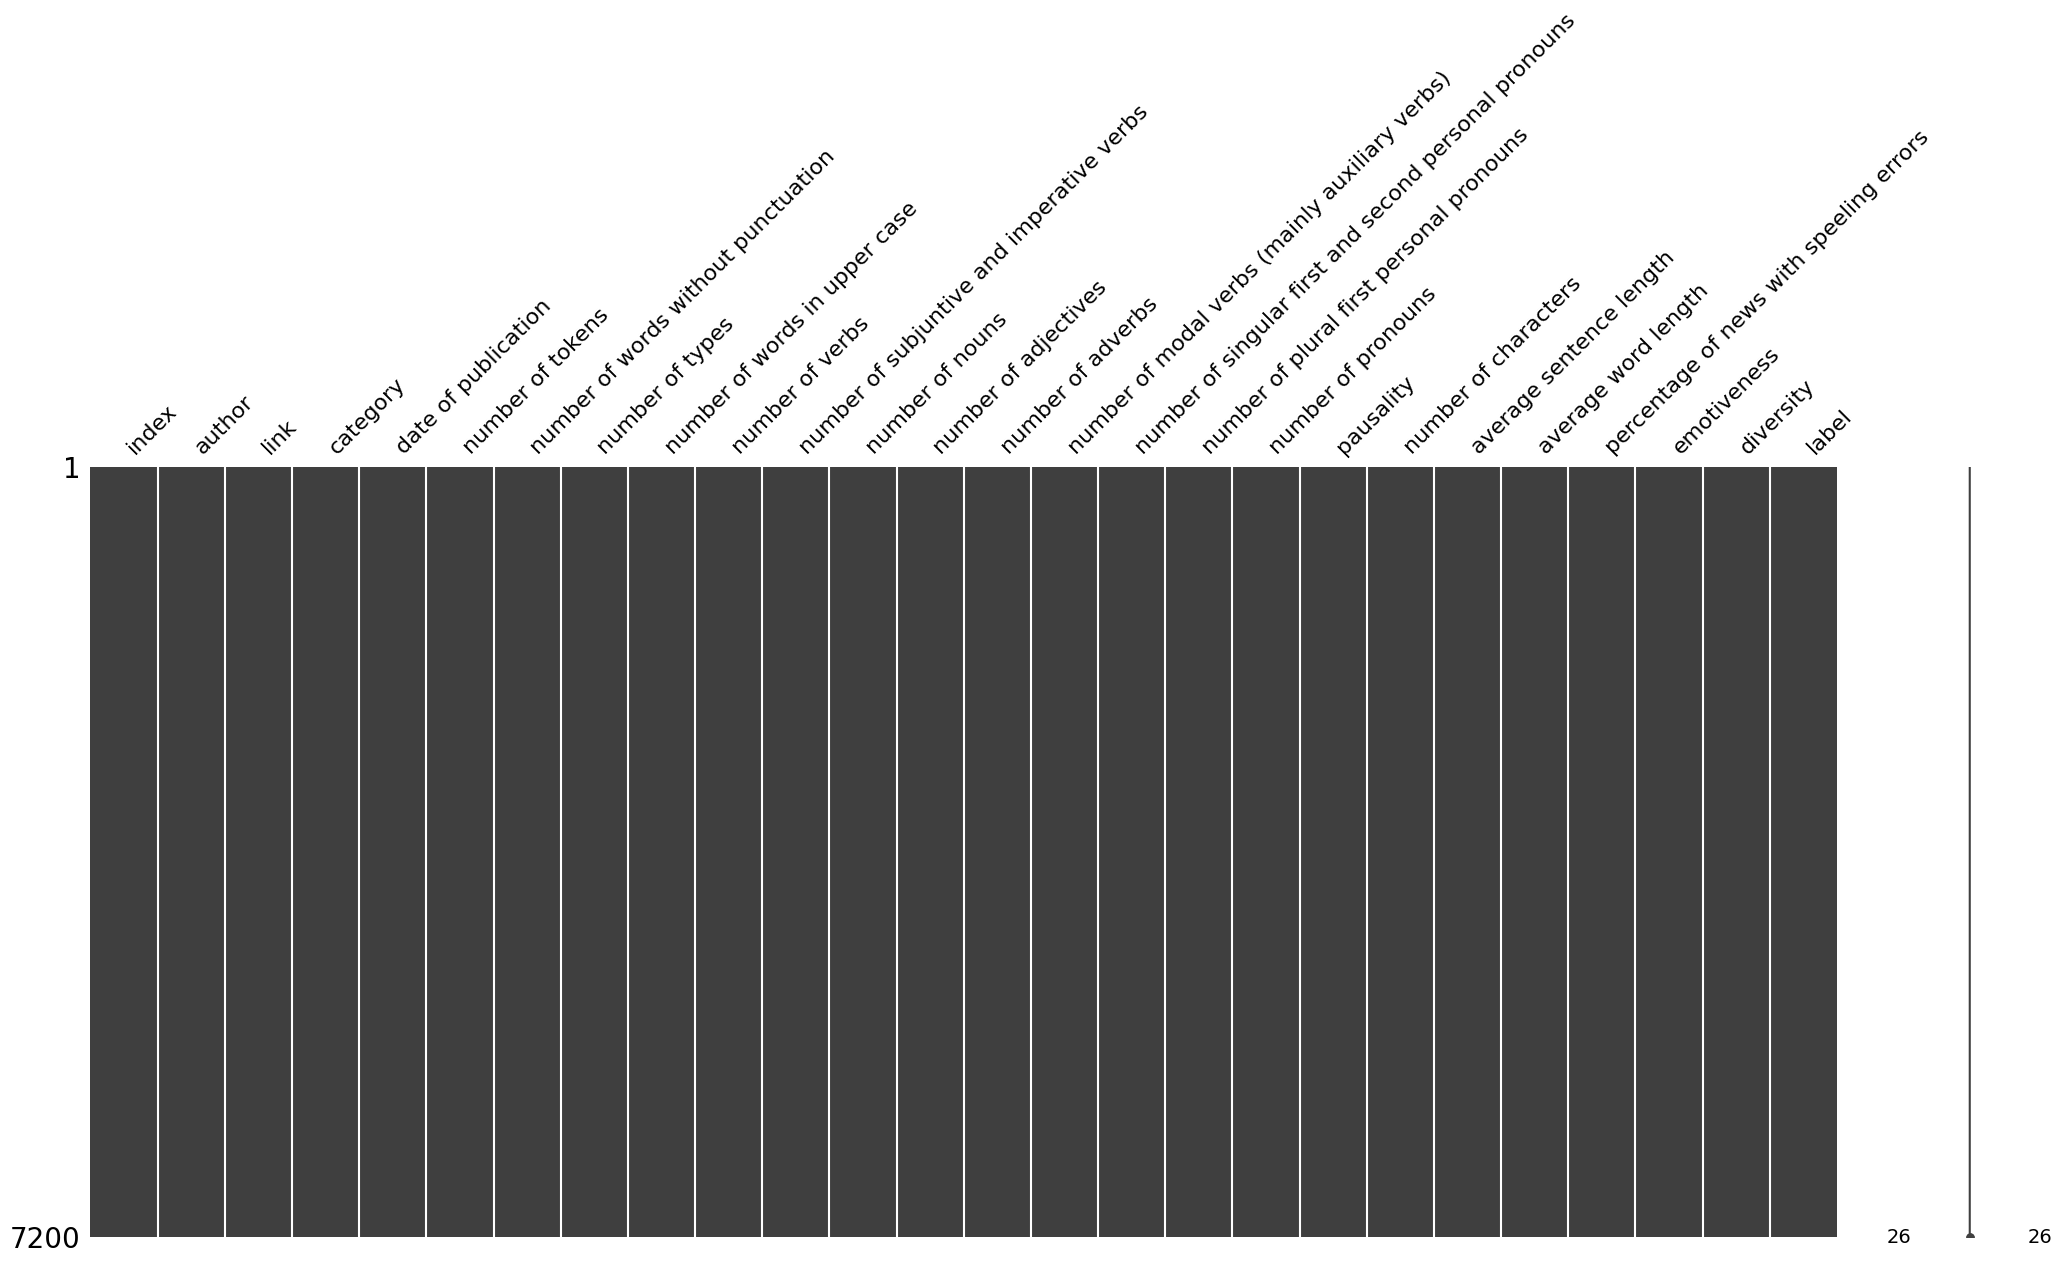

In [15]:
# nesse caso vamos remover a coluna "number of links inside the news" 
# pelos nulos e também pois mais de 75% dos seus valores são zerados, 
# não fazendo sentido manter na analise
# e os autores nulos iremos substituir por strings vazias

df.drop("number of links inside the news", axis=1, inplace=True)
number_coluns.remove("number of links inside the news")
df["author"] = df["author"].replace(np.nan, "")
ms.matrix(df)

Como já é uma base de dados tratada não tivemos que fazer muitas coisas no pre processamento dos dados

## 6. Modelos de Classificação

#### Definição da classe do Pre Processador

In [16]:
class PreProcessador:

    def pre_processar(self, dataset, percentual_teste, seed=7):
        """ Cuida de todo o pré-processamento. """
        # limpeza dos dados e eliminação de outliers

        # feature selection

        # divisão em treino e teste
        X_train, X_test, Y_train, Y_test = self.__preparar_holdout(dataset,
                                                                  percentual_teste,
                                                                  seed)
        # normalização/padronização
        
        return (X_train, X_test, Y_train, Y_test)

    def __preparar_holdout(self, df, percentual_teste, seed):
        """ Divide os dados em treino e teste usando o método holdout.
        Assume que a variável target está na última coluna.
        O parâmetro test_size é o percentual de dados de teste.
        """
        dados = df.values
        X = dados[:, 0:-1]
        Y = dados[:, -1]
        return train_test_split(X, Y, test_size=percentual_teste, random_state=seed)

In [17]:
# definindo o corte e a semente 
test_size = 0.20
seed = 7

pre_processador = PreProcessador()
colunms_to_consider = number_coluns.copy()
colunms_to_consider.append("label")
X_train, X_test, y_train, y_test = pre_processador.pre_processar(df[colunms_to_consider], 
                                                               test_size)


# X_train_transform, X_test_transform, y_train_transform, y_test_transform = pre_processador.pre_processar(df, test_size)
# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10

kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed)

### Analisando os melhores parametros para cada modelo

In [87]:
# Analisando o melhor SVM

# hiperparâmetros que serão avaliados
param_grid = {
  'C': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0],
  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

# modelo - algoritmo Arvore de decisão
model = SVC()
# model.fit(X_train, y_train)
# predicoes = model.predict(X_test)
# accuracy_score(y_test, predicoes)
# busca exaustiva de hiperparâmetros com GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    scoring=scoring, cv=kfold)
grid.fit(X_train, y_train) # dados brutos

# imprime o melhor resultado
print("Melhor: %f usando %s" % 
      (grid.best_score_, grid.best_params_))


In [18]:
# Processo de GridSearch 

models = []

#  KNN
k = [1,3,5,7,9,11,13,15,17,19,21]
distancias = ["euclidean", "manhattan", "minkowski"]
param_grid = dict(n_neighbors=k, metric=distancias)
models.append(("KNN", KNeighborsClassifier(), param_grid))

# Decision Tree
criterion = ['gini','entropy']
max_depth = [3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
param_grid = {'criterion': criterion,'max_depth': max_depth}
models.append(("Decision Tree", DecisionTreeClassifier(), param_grid))

# Navie Bayes 
param_grid = {'var_smoothing': np.logspace(0,-9, num=20)}
models.append(("Navie Bayes", GaussianNB(), param_grid))

# SVM
param_grid = {
  'C': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0],
  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}
# models.append(("SVM", SVC(), param_grid))

for name, model, param_grid in models:
  grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    scoring=scoring, cv=kfold)
  grid.fit(X_train, y_train) 

  # imprime o melhor resultado
  print("Melhor %s : %f usando %s" % 
        (name, grid.best_score_, grid.best_params_))

Melhor KNN : 0.949306 usando {'metric': 'manhattan', 'n_neighbors': 5}
Melhor Decision Tree : 0.949653 usando {'criterion': 'entropy', 'max_depth': 5}
Melhor Navie Bayes : 0.923611 usando {'var_smoothing': 1.8329807108324375e-05}


### Criação e avaliação dos modelos

In [21]:
np.random.seed(7) # definindo uma semente global

# armazeando os pipelines e os resultados para todas as visões do dataset
# como sao datasets diferentes, pelos tratamentos, irei definir dois pipelines 
pipelines = []
results = []
names = []

# definindo os parâmetros do classificador base para o ensambles
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier(metric="manhattan", n_neighbors=5))
cart = ('CART', DecisionTreeClassifier(criterion="gini", max_depth = 5))
naive_bayes = ('NB', GaussianNB(var_smoothing=1e-9))
svm = ('SVM', SVC(C = 1.7, kernel = "linear"))
bagging = ('Bag', BaggingClassifier(base_estimator=base, 
                                    n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, 
                                              max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, 
                                          max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))


# Montando os pipelines

# Dataset original
pipelines.append(('LR', Pipeline([reg_log]))) 
pipelines.append(('KNN', Pipeline([knn])))
pipelines.append(('CART', Pipeline([cart])))
pipelines.append(('NB', Pipeline([naive_bayes])))
pipelines.append(('SVM', Pipeline([svm])))
pipelines.append(('Bag', Pipeline([bagging])))
pipelines.append(('RF', Pipeline([random_forest])))
pipelines.append(('ET', Pipeline([extra_trees])))
pipelines.append(('Ada', Pipeline([adaboost])))
pipelines.append(('GB', Pipeline([gradient_boosting])))
pipelines.append(('Vot', Pipeline([voting])))


# Executando os pipelines - datasets SEM transformações
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) 
    print(msg)

LR: 0.952 (0.008)
KNN: 0.949 (0.012)
CART: 0.947 (0.010)
NB: 0.918 (0.012)
SVM: 0.954 (0.010)
Bag: 0.955 (0.010)
RF: 0.956 (0.008)
ET: 0.955 (0.009)
Ada: 0.950 (0.011)
GB: 0.953 (0.009)
Vot: 0.952 (0.010)


Os resultados foram muito positivos, isso pode ser por conta de algum viés na forma de escrite de fakenews